# Atrium Segmentation

Automatically segment the left atrium in cardiac MRI images

### Medical Background
- Left atrium: one of the four chambers of the heart. The left atrium receives blood full of oxygen from the lungs and then empties the blood into the left ventricle.
- (Left) Atrium Segmentation classifies each voxel in the MRI into either "Not Left Atrium" or " Left Atrium"
- Enables exact volume calculation
- Changes in atrial volume are assoicated with cardiac disorders, such as atrial fibrillation or mitral valve stenosis (Narrowing of the mitral valve orifice, blocking blood flow)
- Segmentation of the left atrium (LA) is required to evaluate atrial size and function, which are important imaging biomarkers for a wide range of cardiovascular conditions, such as atrial fibrillation, stroke, and diastolic dysfunction
- Manual segmentation is tedious,, want to Automatize it !!


Atrial fibrillation (A-fib) is an irregular and often very rapid heart rhythm (arrhythmia) that can lead to blood clots in the heart. A-fib increases the risk of stroke, heart failure and other heart-related complications.

During atrial fibrillation, the heart's upper chambers (the atria) beat chaotically and irregularly — out of sync with the lower chambers (the ventricles) of the heart. For many people, A-fib may have no symptoms. However, A-fib may cause a fast, pounding heartbeat (palpitations), shortness of breath or weakness.

Blood clots are a dangerous complication of atrial fibrillation that can lead to stroke.

In atrial fibrillation, the chaotic heart rhythm can cause blood to collect in the heart's upper chambers (atria) and form clots. If a blood clot in the left upper chamber (left atrium) breaks free from the heart area, it can travel to the brain and cause a stroke.

### Data
- Medical Segmentation Decathlon (http://medicaldecathlon.com/)
- 20 MRI scans of the heart with corresponding Ground Truth mask (https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2)
- 4542 2D MRI and label slices

### Preprocessing
- 2 ways to tackle this problem, work in 3D by using 3Dconv, but this is extremly memory computing expensive
- Therefore, will work in 2D setting by extracting the single slices:
    - Two dimensional setting. Extract slices!
- Original image shape (352 x 352)
    - Crop away non-cardiac regions and background
        - 32 px from all borders (32 rows or columns)
        - Also applied this transformation to segmentation mask!! important
- Z-Normalization per subject:
    - Compute mean and standard deviation for each subject separately
- Standardize the normalized subject into the interval [0, 1]
- Use 16 patients as training data and the remaining 4 for validation

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
root= Path("Task02_Heart/imagesTr/")
label= Path("Task02_Heart/labelsTr/")

In [3]:
def change_img_to_label_path(path): #replaces imagesTr by labelsTr to simplfy process of loading an MRI scan with its label mask
    parts = list(path.parts)  # all directories in path
    parts[parts.index("imagesTr")] = "labelsTr" # replaces imagesTr by labelsTr
    return Path(*parts)  # create new path object

In [4]:
sample_path = list(root.glob("la*"))[0] # first element in the root as sample (all starts with la)
sample_path_label = change_img_to_label_path(sample_path) # store the label path for this sample

In [5]:
sample_path, sample_path_label  # everything is ok

(WindowsPath('Task02_Heart/imagesTr/la_003.nii.gz'),
 WindowsPath('Task02_Heart/labelsTr/la_003.nii.gz'))

In [6]:
data = nib.load(sample_path) # load this sample cardiac MRI
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [7]:
nib.aff2axcodes(data.affine)  # orientation of the scan

('R', 'A', 'S')

In [8]:
from celluloid import Camera  # capture each slice of scan and create a video
from IPython.display import HTML

<IPython.core.display.Javascript object>


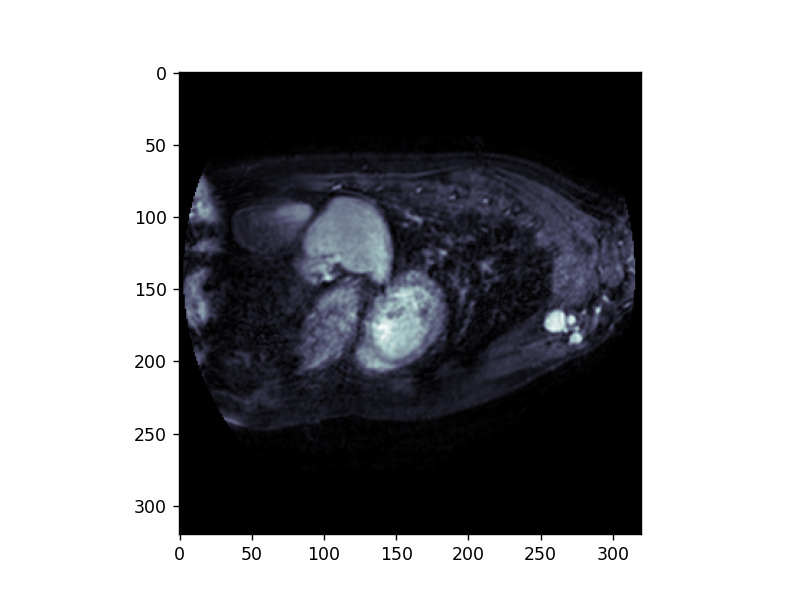

In [9]:
fig = plt.figure()
camera = Camera(fig) # path the fig to the camera

for i in range(mri.shape[2]): # loop over 3rd axis of the scan, RAS orientatio: 3rd axis gets us sagital view
    
    plt.imshow(mri[:,:,i], cmap= "bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i]) # sure we dont overwrite the original mask 
                              # where: mask[:,:,i]==0 , want to mask them so plt doesnt display them
    plt.imshow (mask_ , alpha=0.5)
    camera.snap()
animation=camera.animate()

# we can see, all pixels assosiated with left atrium are visualized

In [10]:
#pass the animation, convert it to an HDML5 video and visualize it in jupyter
HTML(animation.to_html5_video())

In [11]:
# Start preprocessing
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):  # normalized scan
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [12]:
all_files= list(root.glob("la*"))  # anything starts with la
len(all_files)

20

In [13]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate (tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S") # make sure that scan has RAS orientation
    
    mri_data = mri.get_fdata() # extract array from the nifty file
    
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8) # load the mask, extract the np array, convert it to int
    
    mri_data = mri_data[32:-32, 32:-32]  # crop 32 pixels from top and bottom, left and right
    label_data = label_data[32:-32, 32:-32] 
    
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    if counter < 17:  # check wheather we are in train or validation split, want to use first 16 for training
        current_path = save_root/"train"/str(counter)  # separate directory for each patient
    else:
        current_path = save_root/"val"/str(counter)
        
    # loop over the single slices of the current scan and store them together with their corresponding segmentation map 
    for i in range(standardized_mri_data.shape[-1]):  # -1 > last axis of standardized_mri_data
        
        slice = standardized_mri_data[:,:,i]        # extract the current slice       
        mask = label_data[:,:,i]
        slice_path = current_path/"data"  # save path
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True) # make sure it exists
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice) # store the slice in its directory, i is the file name
        np.save(mask_path/str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
path = Path("Preprocessed/train/0")  # preprocessed files

In [15]:
file= "50.npy"  # file num 50
slice = np.load(path/"data"/file) # load slice and mask
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


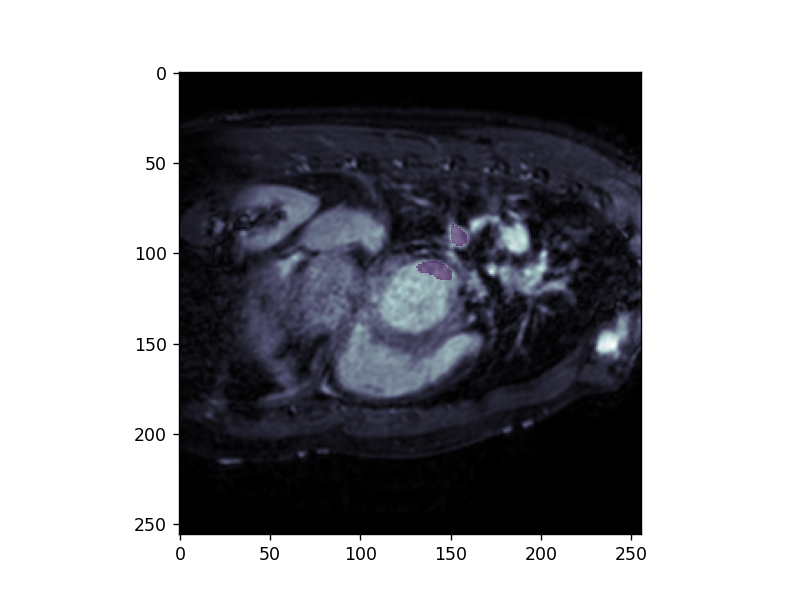

In [16]:
# visualize this slice with the mask on top of it
plt.figure()
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)  # masking all elements which are 0 in the mask
plt.imshow(mask_, alpha=0.5)